Pipeline notebook

In [ ]:
# initial setup and clone repository
# need access to probeeng repo to run properly

import os
#insert keys
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

# clone repository
# insert pat and repo_url
pat = ""
repo_url = f""
!git clone $repo_url
%cd /content/probeeng
!git checkout -b alinashah

# install all dependencies using the requirements file
!pip install -r requirements_colab.txt

# force install sklearn 1.4.2 to ensure we don't get 1.5.x
print("\n Forcing scikit-learn 1.4.2...")
!pip install --force-reinstall scikit-learn==1.4.2

Cloning into 'probeeng'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 439 (delta 4), reused 2 (delta 0), pack-reused 403 (from 1)
Receiving objects: 100% (439/439), 1.20 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/probeeng
Switched to a new branch 'alinashah'
  Cloning https://github.com/mishajw/mppr.git (to revision 8773ad65add584b53d5488ba3974ea8847884a9c) to /tmp/pip-install-ai1io9fy/mppr_51160ce8e7f347fbbeaaebac7cf74826
  Running command git clone --filter=blob:none --quiet https://github.com/mishajw/mppr.git /tmp/pip-install-ai1io9fy/mppr_51160ce8e7f347fbbeaaebac7cf74826
  Running command git rev-parse -q --verify 'sha^8773ad65add584b53d5488ba3974ea8847884a9c'
  Running command git fetch -q https://github.com/mishajw/mppr.git 8773ad65add584b53d5488ba3974ea8847884a9c
  Resolved https://github.com/mishajw/mppr.git to commit 8773ad65add584b53d5488ba3974


 Forcing scikit-learn 1.4.2...
  Using cached scikit_learn-1.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
Using cached scikit_learn-1.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: jobli

In [ ]:
%cd /content/probeeng
from pathlib import Path
import re

p = Path("experiments/presets/probe_training.toml")
txt = p.read_text()

block = """
[presets.alina_mvp]
tag = "alina_mvp_train"
llm_ids = ["Llama-2-7b-chat-hf"]
dataset_collections = ["got"]
probe_methods = ["lr"]
layers_start = 1
layers_end   = 19
layers_skip  = 2
token_idxs   = [0]
""".strip()

pattern = r"\[presets\.alina_mvp\][\s\S]*?(?=\n\[presets\.|\Z)"
if re.search(pattern, txt, flags=re.M):
    txt = re.sub(pattern, block, txt, flags=re.M)
else:
    txt = txt.rstrip() + "\n\n" + block + "\n"

p.write_text(txt)
print("Updated probe_training preset to 10 layers (1..19 skip 2).")


/content/probeeng
Updated probe_training preset to 10 layers (1..19 skip 2).


In [ ]:
from pathlib import Path
import re, textwrap

root = Path("/content/probeeng/experiments/presets")

def replace_block(path: Path, block_name: str, new_block: str):
    txt = path.read_text()
    # remove any existing [presets.alina_mvp] block
    pattern = re.compile(rf'(?ms)^\[presets\.{re.escape(block_name)}\]\s.*?(?=^\[presets\.|\Z)')
    txt = re.sub(pattern, '', txt).rstrip() + "\n\n" + new_block.strip() + "\n"
    path.write_text(txt)
    print(f"wrote {path.name} → [presets.{block_name}]")

# ---- dataset_creation.toml ----
# CPU-friendly: use gpt2, last token, 10 layers (2..11)
dataset_creation_block = textwrap.dedent("""
[presets.alina_mvp]
tag = "alina_mvp_dataset"
llm_ids = ["Llama-2-7b-chat-hf"]
dataset_collections = ["got"]
num_tokens_from_end = 1
device = "cuda"
layers_start = 1
layers_end   = 19
layers_skip  = 2
""")

# ---- probe_training.toml ----
# IMPORTANT: no `device` here; `probe_methods` must use valid names (e.g., "lr")
# token_idxs = [0] because we extracted 1 token from end (see docs)
probe_training_block = textwrap.dedent("""
[presets.alina_mvp]
tag = "alina_mvp_train"
llm_ids = ["Llama-2-7b-chat-hf"]
dataset_collections = ["got"]
probe_methods = ["dim"]
layers_start = 1
layers_end   = 19
layers_skip  = 2
token_idxs   = [0]
""")

# ---- probe_evaluation.toml ----
# Minimal evaluation config; keep it simple for MVP
probe_evaluation_block = textwrap.dedent("""
[presets.alina_mvp]
tag = "alina_mvp_eval"
datasets = []
dataset_collections = ["got"]
eval_splits = ["validation"]
output_formats = ["csv", "json"]
generate_plots = true
advanced_plots = true
calculate_recovered_accuracy = true
generate_rankings = true
""")

replace_block(root / "dataset_creation.toml", "alina_mvp", dataset_creation_block)
replace_block(root / "probe_training.toml",   "alina_mvp", probe_training_block)
replace_block(root / "probe_evaluation.toml", "alina_mvp", probe_evaluation_block)


wrote dataset_creation.toml → [presets.alina_mvp]
wrote probe_training.toml → [presets.alina_mvp]
wrote probe_evaluation.toml → [presets.alina_mvp]


In [ ]:
import os
#input keys here
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

# 1) go to the repo
%cd /content/probeeng

# 2) (once per session) login to Hugging Face with a READ token that has Llama-2 access
from huggingface_hub import login
#input token here
login(token="")

# 3) set PYTHONPATH for this notebook session
%env PYTHONPATH=/content/probeeng:$PYTHONPATH

# 4) run the pipeline
!python experiments/run_pipeline.py standard alina_mvp --output-dir /content/probeeng/output/


/content/probeeng
env: PYTHONPATH=/content/probeeng:$PYTHONPATH
Loading presets from: experiments/presets/dataset_creation.toml
Loading presets from: experiments/presets/probe_training.toml
Loading presets from: experiments/presets/probe_evaluation.toml

Preset: alina_mvp
Tag: alina_mvp_dataset

Executing pipeline...
2025-09-30 14:39:11.769001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 14:39:11.786768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759243151.808470    8716 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0

In [ ]:
!pip -q install awscli
import os
import os

#input keys and region here
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ["AWS_DEFAULT_REGION"] = ""

# list the experiment paths the pipeline uses
!aws s3 ls s3://probeengbucket/experiments/
!aws s3 ls s3://probeengbucket/experiments/alina_mvp_dataset/datasets/
!aws s3 ls s3://probeengbucket/experiments/alina_mvp_train/
!aws s3 ls s3://probeengbucket/experiments/alina_mvp_eval/


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.38.8 requires botocore<1.39.0,>=1.38.8, but you have botocore 1.40.41 which is incompatible.
boto3 1.38.8 requires s3transfer<0.13.0,>=0.12.0, but you have s3transfer 0.14.0 which is incompatible.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
                           PRE alina_mvp_dataset/
                           PRE alina_mvp_train/
2025-09-30 14:39:17  737273701 activations.pickle
                           PRE probes/


In [ ]:
 # Run this in a *bash* cell
%%bash
cd /content/probeeng

#  make sure aws cli exists (safe to rerun)
pip -q install awscli >/dev/null 2>&1 || true

# create local folders
mkdir -p output/datasets output/probes/alina_mvp_train output/evaluations/alina_mvp_eval

# pull your artifacts from S3 to the repo
aws s3 cp s3://probeengbucket/experiments/alina_mvp_dataset/datasets/activations.pickle output/datasets/ || true
aws s3 sync s3://probeengbucket/experiments/alina_mvp_train/ output/probes/alina_mvp_train/
aws s3 sync s3://probeengbucket/experiments/alina_mvp_eval/ output/evaluations/alina_mvp_eval/ || true

# check
ls -lah output/probes/alina_mvp_train | head -n 50



download: s3://probeengbucket/experiments/alina_mvp_dataset/datasets/activations.pickle to output/datasets/activations.pickle
download: s3://probeengbucket/experiments/alina_mvp_train/probes/manifest.json to output/probes/alina_mvp_train/probes/manifest.json
download: s3://probeengbucket/experiments/alina_mvp_train/probes/probes.pickle to output/probes/alina_mvp_train/probes/probes.pickle
total 1.7M
drwxr-xr-x 4 root root 4.0K Sep 30 14:48 .
drwxr-xr-x 3 root root 4.0K Sep 30 14:35 ..
drwxr-xr-x 2 root root 4.0K Sep 30 14:35 alina_mvp_train
-rw-r--r-- 1 root root 7.7K Sep 30 14:39 manifest.json
drwxr-xr-x 2 root root 4.0K Sep 30 14:48 probes
-rw-r--r-- 1 root root 1.7M Sep 30 14:35 probe_train-v1.pickle


In [ ]:
import os, gc, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# clean any old models
for name in ("model","tok"):
    if name in globals(): del globals()[name]
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

from transformers import AutoTokenizer, AutoModelForCausalLM
MODEL_ID = "meta-llama/Llama-2-7b-chat-hf"

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="auto",
)
model.eval()
# IMPORTANT: do NOT call .to("cuda") after using device_map="auto"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_e

In [ ]:
import gc, torch, os
if 'model' in globals(): del model
if 'tok' in globals(): del tok
gc.collect(); torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
MODEL_ID = "meta-llama/Llama-2-7b-chat-hf"

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype="auto",
    low_cpu_mem_usage=True,
    device_map="cuda",
).eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch, numpy as np, pickle, re
from pathlib import Path
from math import exp

MODEL_ID = "meta-llama/Llama-2-7b-chat-hf"   # same model you loaded in fp16
PROBE_FILE = Path("output/probes/alina_mvp_train/probes/probes.pickle")

assert 'model' in globals() and 'tok' in globals(), "Load model/tokenizer first."
assert PROBE_FILE.exists(), f"Missing {PROBE_FILE}"

# ---- load probes dict[str -> TrainedProbe]
with open(PROBE_FILE, "rb") as f:
    probes_dict = pickle.load(f)
print(f"Loaded {len(probes_dict)} trained probes")

# pick 10 layers (match what you trained: 1..19 skip 2)
LAYERS = [1,3,5,7,9,11,13,15,17,19]

# choose exactly one probe per layer
layer_to_probe = {}
for L in LAYERS:
    # keys look like: "Llama-2-7b-chat-hf-<dataset>-lr-h{L}-0"
    pat = re.compile(rf"{re.escape(MODEL_ID.split('/')[-1])}-.+-lr-h{L}-0$")
    # try prefer got_cities
    candidates = [k for k in probes_dict.keys() if pat.search(k)]
    pref = [k for k in candidates if "-got_cities-" in k] or candidates
    if pref:
        layer_to_probe[L] = probes_dict[pref[0]]
    else:
        print(f"Warning: no probe found for layer {L}")

print("Using layers:", sorted(layer_to_probe.keys()))

# small helpers
def _sigmoid(x):
    try:
        return 1.0/(1.0+exp(-float(x)))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

def probe_to_estimator(tp):
    """
    ProbeEng's TrainedProbe stores a serialized sklearn model.
    Its instance method `deserialize_probe(probe_data)` needs the payload.
    We'll try common field names and, if needed, scan the model_dump.
    """
    # 1) common attribute names
    for attr in ("probe", "probe_data", "serialized_probe", "estimator_data", "data"):
        if hasattr(tp, attr):
            payload = getattr(tp, attr)
            if payload is not None:
                try:
                    return tp.deserialize_probe(payload)
                except Exception as e:
                    last_err = e  # try next candidate

    # 2) search inside the pydantic payload
    dump = {}
    try:
        dump = tp.model_dump()
    except Exception:
        try:
            dump = tp.dict()
        except Exception:
            dump = {}

    # look for a dict that smells like a serialized payload
    for k, v in dump.items():
        if isinstance(v, dict) and any(x in v for x in ("data", "bytes", "blob", "pickle", "b64", "content", "payload")):
            try:
                return tp.deserialize_probe(v)
            except Exception as e:
                last_err = e

    # 3) if we still couldn't get it, show helpful debug info
    raise RuntimeError(
        "Could not deserialize sklearn estimator from TrainedProbe.\n"
        f"Fields seen: {list(dump.keys())[:15]}"
    )


def layer_last_token_vec(text: str, layer: int) -> np.ndarray:
    toks = tok(text, return_tensors="pt", add_special_tokens=True)
    toks = {k: v.to(model.device) for k, v in toks.items()}
    with torch.no_grad():
        out = model(**toks, output_hidden_states=True)
    # hidden_states[0]=embeddings, [1]=after layer 1, ... so h{L} = index L
    hs = out.hidden_states[layer]           # [1, seq, hidden]
    vec = hs[:, -1, :].detach().cpu().numpy()  # last token
    return vec  # shape (1, hidden)

def est_proba01(est, X_np):
    """
    Return a probability in [0,1] from a variety of estimator APIs.
    Handles sklearn (predict_proba / decision_function / predict) and
    ProbeEng PredictResult-style returns.
    """
    def _sigmoid(x):
        return float(1.0 / (1.0 + np.exp(-float(x))))

    # 1) Standard sklearn path
    if hasattr(est, "predict_proba"):
        proba = est.predict_proba(X_np)
        proba = np.asarray(proba)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return float(proba[0, 1])
        return float(proba.ravel()[0])

    if hasattr(est, "decision_function"):
        score = est.decision_function(X_np)
        if isinstance(score, (list, tuple, np.ndarray)):
            score = np.asarray(score).ravel()[0]
        return _sigmoid(score)

    # 2) Generic predict path (may be ndarray OR a PredictResult-like object)
    y = est.predict(X_np)

    # 2a) If it's array-like, grab first element
    if isinstance(y, (list, tuple, np.ndarray)):
        return float(np.asarray(y).ravel()[0])

    # 2b) If it's a PredictResult-like object, try common fields
    for attr in ("proba", "probs", "probabilities", "y_proba"):
        if hasattr(y, attr):
            arr = np.asarray(getattr(y, attr))
            if arr.ndim == 2 and arr.shape[1] >= 2:
                return float(arr[0, 1])
            return float(np.clip(arr.ravel()[0], 0.0, 1.0))

    for attr in ("scores", "logits"):
        if hasattr(y, attr):
            arr = np.asarray(getattr(y, attr))
            return _sigmoid(arr.ravel()[0])

    for attr in ("pred", "prediction", "label", "y"):
        if hasattr(y, attr):
            return float(getattr(y, attr))

    # 2c) Scalar fallback
    if np.isscalar(y):
        return float(y)

    raise RuntimeError(f"Estimator predict returned unsupported object of type {type(y)}")


def get_credences(claim: str) -> dict:
    res = {}
    for L, tp in layer_to_probe.items():
        est = probe_to_estimator(tp)
        x = layer_last_token_vec(claim, L)
        res[f"L{L}"] = est_proba01(est, x)
    return res

# TYPE YOUR CLAIM HERE
claim = "Chicago is in Illinois"
credences = get_credences(claim)
for k in sorted(credences, key=lambda s: int(s[1:])):
    print(f"{k}: {credences[k]:.3f}")


AssertionError: Load model/tokenizer first.

In [ ]:
import pandas as pd

# main table
df = pd.read_csv("output/evaluations/alina_mvp_eval/results.csv")
print(df.shape)
print(df.columns.tolist())
df.head(10)


(250, 14)
['accuracy', 'n', 'llm_id', 'train_dataset', 'eval_dataset', 'probe_method', 'layer', 'token_idx', 'split', 'is_supervised', 'is_grouped', 'same_dataset', 'threshold', 'recovered_accuracy']


,accuracy,n,llm_id,train_dataset,eval_dataset,probe_method,layer,token_idx,split,is_supervised,is_grouped,same_dataset,threshold,recovered_accuracy
0,0.500000,100,Llama-2-7b-chat-hf,got_cities,got_cities,lr,1,0,validation,True,False,True,1.00,0.500000
1,0.523077,65,Llama-2-7b-chat-hf,got_cities,got_sp_en_trans,lr,1,0,validation,True,False,False,1.00,0.523077
2,0.520000,100,Llama-2-7b-chat-hf,got_cities,got_cities_cities_conj,lr,1,0,validation,True,False,False,0.97,0.536082
3,0.530000,100,Llama-2-7b-chat-hf,got_cities,got_cities_cities_disj,lr,1,0,validation,True,False,False,0.94,0.563830
4,0.550000,100,Llama-2-7b-chat-hf,got_cities,got_larger_than,lr,1,0,validation,True,False,False,1.00,0.550000
5,0.520000,100,Llama-2-7b-chat-hf,got_cities,got_cities,lr,3,0,validation,True,False,True,1.00,0.520000
6,0.523077,65,Llama-2-7b-chat-hf,got_cities,got_sp_en_trans,lr,3,0,validation,True,False,False,1.00,0.523077
7,0.530000,100,Llama-2-7b-chat-hf,got_cities,got_cities_cities_conj,lr,3,0,validation,True,False,False,0.97,0.546392
8,0.580000,100,Llama-2-7b-chat-hf,got_cities,got_cities_cities_disj,lr,3,0,validation,True,False,False,0.94,0.617021
9,0.530000,100,Llama-2-7b-chat-hf,got_cities,got_larger_than,lr,3,0,validation,True,False,False,1.00,0.530000


In [ ]:
import pandas as pd

df = pd.read_csv("output/evaluations/alina_mvp_eval/results.csv")

# Overall mean accuracy per layer (averaged over all train/eval pairs)
overall_by_layer = (df.groupby("layer")["accuracy"]
                      .mean()
                      .sort_values(ascending=False))
print("Overall mean accuracy by layer:\n", overall_by_layer.head(10))

# Cross-dataset generalization (exclude same_dataset)
xd = df[df["same_dataset"] == False]
xgen_by_layer = (xd.groupby("layer")["accuracy"]
                   .mean()
                   .sort_values(ascending=False))
print("\nCross-dataset mean accuracy by layer:\n", xgen_by_layer.head(10))


Overall mean accuracy by layer:
 layer
17    0.802492
19    0.793323
15    0.783631
13    0.776800
11    0.766892
9     0.658400
7     0.572738
5     0.557108
3     0.543815
1     0.535231
Name: accuracy, dtype: float64

Cross-dataset mean accuracy by layer:
 layer
17    0.759115
19    0.746154
15    0.736538
13    0.728000
11    0.724615
9     0.613000
7     0.558846
5     0.556308
3     0.546115
1     0.535385
Name: accuracy, dtype: float64


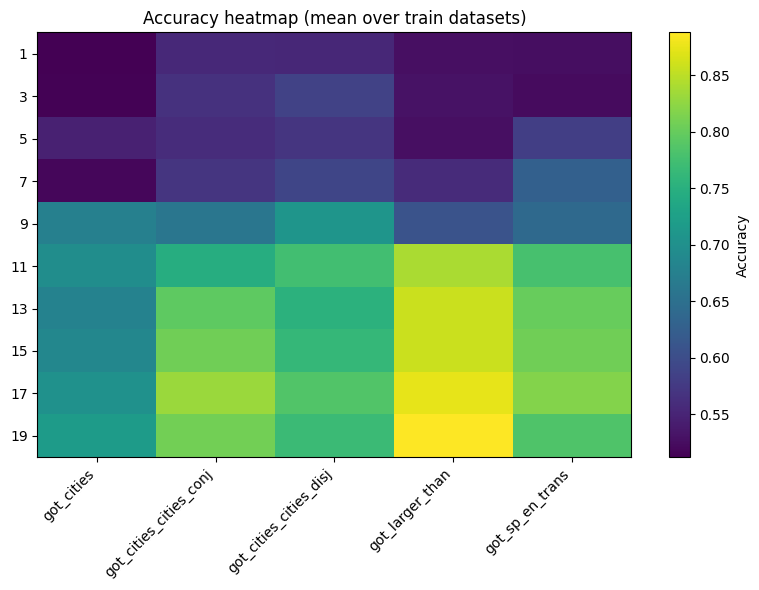

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pivot = (df.groupby(["layer","eval_dataset"])["accuracy"]
           .mean()
           .reset_index()
           .pivot(index="layer", columns="eval_dataset", values="accuracy")
           .sort_index())

plt.figure(figsize=(8,6))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.colorbar(label="Accuracy")
plt.title("Accuracy heatmap (mean over train datasets)")
plt.tight_layout()
plt.show()


In [ ]:
same = (df[df["same_dataset"] == True].groupby("layer")["accuracy"].mean())
diff = (df[df["same_dataset"] == False].groupby("layer")["accuracy"].mean())
gap = (same - diff).dropna().sort_values(ascending=False)
print("Generalization gap (same - cross) by layer:\n", gap.head(10))


Generalization gap (same - cross) by layer:
 layer
13    0.244000
19    0.235846
15    0.235462
9     0.227000
17    0.216885
11    0.211385
7     0.069462
5     0.004000
1    -0.000769
3    -0.011500
Name: accuracy, dtype: float64


In [ ]:
# Choose the 10 most generalizable layers
top10_layers = xgen_by_layer.index[:10].tolist()
print("MVP layers:", top10_layers)

# Save for your inference notebook
pd.Series(top10_layers, name="layer").to_frame().to_csv("mvp_layers.csv", index=False)


MVP layers: [17, 19, 15, 13, 11, 9, 7, 5, 3, 1]


In [ ]:
# choose one training dataset to define 10 probes
TRAIN_DS = "got_cities"

# load the big probes dict downloaded from S3:
import pickle, re
from pathlib import Path
PROBES_PATH = Path("output/probes/alina_mvp_train/probes/probes.pickle")

with open(PROBES_PATH, "rb") as f:
    all_probes = pickle.load(f)   # dict[str -> TrainedProbe]

# keep only keys that match this dataset and layers 1,3,...,19
want_layers = {1,3,5,7,9,11,13,15,17,19}
selected = {}
for k, tp in all_probes.items():
    # keys look like: Llama-2-7b-chat-hf-<DATASET>-lr-h{layer}-0
    if f"-{TRAIN_DS}-" in k:
        m = re.search(r"-h(\d+)-0$", k)
        if m:
            L = int(m.group(1))
            if L in want_layers:
                selected[f"L{L}"] = tp

print("Picked", len(selected), "probes:", sorted(selected))



Picked 10 probes: ['L1', 'L11', 'L13', 'L15', 'L17', 'L19', 'L3', 'L5', 'L7', 'L9']


In [ ]:
# SELECTIONS
SELECT_DATASET = "got_cities"
LAYERS = [1,3,5,7,9,11,13,15,17,19]

PROBES_PATH = "output/probes/alina_mvp_train/probes/probes.pickle"
MODEL_ID = "meta-llama/Llama-2-7b-chat-hf"

# ---- load probes ------------------------------------------------
import pickle, re
with open(PROBES_PATH, "rb") as f:
    probes = pickle.load(f)

# ---- build {layer -> probe} using selections ---------------
DATASETS = [
    "got_cities", "got_sp_en_trans",
    "got_cities_cities_conj", "got_cities_cities_disj",
    "got_larger_than"
]

layer_to_probe = {}
for key, tp in probes.items():
    # parse dataset from key
    ds = next((d for d in DATASETS if f"-{d}-" in key), None)
    m = re.search(r"-h(\d+)-", key)
    layer = int(m.group(1)) if m else None
    if ds == SELECT_DATASET and layer in LAYERS:
        layer_to_probe[layer] = tp

# check
assert set(layer_to_probe.keys()) == set(LAYERS), \
    f"Got {sorted(layer_to_probe)} but expected {LAYERS}"
print("Using layers:", sorted(layer_to_probe))

# ---- 3) keep helper functions exactly as they are -------
# helpers
def _sigmoid(x):
    try:
        return 1.0/(1.0+exp(-float(x)))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

def probe_to_estimator(tp):
    """
    ProbeEng's TrainedProbe stores a serialized sklearn model.
    Its instance method `deserialize_probe(probe_data)` needs the payload.
    We'll try common field names and, if needed, scan the model_dump.
    """
    # 1) common attribute names
    for attr in ("probe", "probe_data", "serialized_probe", "estimator_data", "data"):
        if hasattr(tp, attr):
            payload = getattr(tp, attr)
            if payload is not None:
                try:
                    return tp.deserialize_probe(payload)
                except Exception as e:
                    last_err = e  # try next candidate

    # 2) search inside the pydantic payload
    dump = {}
    try:
        dump = tp.model_dump()
    except Exception:
        try:
            dump = tp.dict()
        except Exception:
            dump = {}

    # look for a dict that smells like a serialized payload
    for k, v in dump.items():
        if isinstance(v, dict) and any(x in v for x in ("data", "bytes", "blob", "pickle", "b64", "content", "payload")):
            try:
                return tp.deserialize_probe(v)
            except Exception as e:
                last_err = e

    # 3) if we still couldn't get it, show helpful debug info
    raise RuntimeError(
        "Could not deserialize sklearn estimator from TrainedProbe.\n"
        f"Fields seen: {list(dump.keys())[:15]}"
    )


def layer_last_token_vec(text: str, layer: int) -> np.ndarray:
    toks = tok(text, return_tensors="pt", add_special_tokens=True)
    toks = {k: v.to(model.device) for k, v in toks.items()}
    with torch.no_grad():
        out = model(**toks, output_hidden_states=True)
    # hidden_states[0]=embeddings, [1]=after layer 1, ... so h{L} = index L
    hs = out.hidden_states[layer]           # [1, seq, hidden]
    vec = hs[:, -1, :].detach().cpu().numpy()  # last token
    return vec  # shape (1, hidden)

def est_proba01(est, X_np):
    """
    Return a probability in [0,1] from a variety of estimator APIs.
    Handles sklearn (predict_proba / decision_function / predict) and
    ProbeEng PredictResult-style returns.
    """
    def _sigmoid(x):
        return float(1.0 / (1.0 + np.exp(-float(x))))

    # 1) Standard sklearn path
    if hasattr(est, "predict_proba"):
        proba = est.predict_proba(X_np)
        proba = np.asarray(proba)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return float(proba[0, 1])
        return float(proba.ravel()[0])

    if hasattr(est, "decision_function"):
        score = est.decision_function(X_np)
        if isinstance(score, (list, tuple, np.ndarray)):
            score = np.asarray(score).ravel()[0]
        return _sigmoid(score)

    # 2) Generic predict path (may be ndarray OR a PredictResult-like object)
    y = est.predict(X_np)

    # 2a) If it's array-like, grab first element
    if isinstance(y, (list, tuple, np.ndarray)):
        return float(np.asarray(y).ravel()[0])

    # 2b) If it's a PredictResult-like object, try common fields
    for attr in ("proba", "probs", "probabilities", "y_proba"):
        if hasattr(y, attr):
            arr = np.asarray(getattr(y, attr))
            if arr.ndim == 2 and arr.shape[1] >= 2:
                return float(arr[0, 1])
            return float(np.clip(arr.ravel()[0], 0.0, 1.0))

    for attr in ("scores", "logits"):
        if hasattr(y, attr):
            arr = np.asarray(getattr(y, attr))
            return _sigmoid(arr.ravel()[0])

    for attr in ("pred", "prediction", "label", "y"):
        if hasattr(y, attr):
            return float(getattr(y, attr))

    # 2c) Scalar fallback
    if np.isscalar(y):
        return float(y)

    raise RuntimeError(f"Estimator predict returned unsupported object of type {type(y)}")


def get_credences(claim: str) -> dict:
    res = {}
    for L, tp in layer_to_probe.items():
        est = probe_to_estimator(tp)
        x = layer_last_token_vec(claim, L)
        res[f"L{L}"] = est_proba01(est, x)
    return res
# ---- 4) ask a claim ------------------------------------------------
claim = "Humans have flown close to the sun."
credences = get_credences(claim)
for k in sorted(credences, key=lambda s: int(s[1:])):
    print(f"{k}: {credences[k]:.3f}")

Using layers: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
L1: 0.505
L3: 0.421
L5: 0.698
L7: 0.828
L9: 0.650
L11: 0.604
L13: 0.888
L15: 0.533
L17: 0.509
L19: 0.271


Run these after restarting